In [0]:
#imports cell 
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.layers import Dense,Input,Flatten,GlobalAveragePooling2D,Dropout,BatchNormalization,Conv2D,Activation,MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras import backend as K
K.set_image_data_format("channels_first")
from tensorflow.keras import optimizers,Sequential

## Mount the Google Drive to Google Colab

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Method for Loading dataset into Memory 

In [0]:
def load_data(plane,label):
  train_X = np.load('/content/gdrive/My Drive/Dataset/Transformations/mid3_train_'+plane+'.npy')
  train_y = np.genfromtxt('/content/gdrive/My Drive/Dataset/MRNet-v1.0/train-'+label+'.csv',delimiter=',')[:,1]
  val_X = np.load('/content/gdrive/My Drive/Dataset/Transformations/mid3_valid_'+plane+'.npy')
  val_y = np.genfromtxt('/content/gdrive/My Drive/Dataset/MRNet-v1.0/valid-'+label+'.csv',delimiter=',')[:,1]
  return train_X,train_y,val_X,val_y

## Defining Our Base Model upon which Transfer Learning is done

In [4]:
base_model = ResNet50(weights='imagenet',input_shape=(3,256,256),include_top=False,input_tensor=Input(shape=(3,256,256)))
for layer in base_model.layers:
  layer.trainable = False

Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


## Defining our Model Built over Base Model and it's Methods

In [0]:
def build_model():
  model = base_model.output
  model = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(model)
  model = BatchNormalization()(model)
  model = Activation('relu')(model)
  model = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(model)
  model = BatchNormalization()(model)
  model = Activation('relu')(model)
  model = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(model)
  model = Flatten()(model)
  model = Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001))(model)
  model = Dropout(0.5)(model)
  model = Dense(32, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001))(model)
  model = Dropout(0.5)(model)
  preds = Dense(1,activation='sigmoid',name='preds')(model)
  model_final=Model(inputs=base_model.input,outputs=preds)
  #sgd = optimizers.SGD(lr=0.0005, decay=0, nesterov=True)
  model_final.compile(optimizer= "adam",loss='binary_crossentropy',metrics=['accuracy'])
  return model_final
  
def show_model(model):
  model.summary()

def train_model(model,plane,label):
  train_X,train_y,val_X,val_y = load_data(plane,label)
  model = build_model()
  mc = ModelCheckpoint('/content/gdrive/My Drive/Models/TransferLearning/'+plane+'_'+label+'.h5', monitor='val_acc', mode='max', verbose=2, save_best_only=True)
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=3)
  history = model.fit(x=train_X, y=train_y,  validation_data=(val_X,val_y), batch_size = 20, epochs=50,verbose=2, callbacks=[mc,es])
  return history
  
def plot_history(histories, key='acc'):
  plt.figure(figsize=(16,10))
  for name, history in histories:
    val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val',color='b')
    plt.plot(history.epoch, history.history[key], color='b',
             label=name.title()+' Train')
  plt.xlabel('Epochs')
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()
  plt.ylim([0,1])
  plt.xlim([0,max(history.epoch)])
  plt.figure(0)
  plt.show()
  
  plt.figure(figsize=(16,10))
  for name, history in histories:
    val = plt.plot(history.epoch, history.history['val_loss'],
                   '--', label=name.title()+' Val',color='r')
    plt.plot(history.epoch, history.history['loss'], color='r',
             label=name.title()+' Train')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.ylim([0,1.5])
  plt.xlim([0,max(history.epoch)])
  plt.show()

## This is How the Final model looks like 

In [6]:
model = build_model()
show_model(model)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 3, 256, 256)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 3, 262, 262)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 64, 128, 128) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalizationV1) (None, 64, 128, 128) 256         conv1[0][0]                 

# Let's Begin Training the Net

## Model 1: Axial Plane and ACL Labels

Train on 1130 samples, validate on 120 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/50

Epoch 00001: val_acc improved from -inf to 0.55000, saving model to /content/gdrive/My Drive/Models/TransferLearning/axial_acl.h5
 - 21s - loss: 0.7697 - acc: 0.7416 - val_loss: 1.2646 - val_acc: 0.5500
Epoch 2/50

Epoch 00002: val_acc did not improve from 0.55000
 - 6s - loss: 0.6514 - acc: 0.7920 - val_loss: 0.9378 - val_acc: 0.5500
Epoch 3/50

Epoch 00003: val_acc did not improve from 0.55000
 - 6s - loss: 0.6276 - acc: 0.8044 - val_loss: 0.8228 - val_acc: 0.5500
Epoch 4/50

Epoch 00004: val_acc did not improve from 0.55000
 - 6s - loss: 0.5906 - acc: 0.8133 - val_loss: 0.8221 - val_acc: 0.5500
Epoch 5/50

Epoch 00005: val_acc did not improve from 0.55000
 - 6s - loss: 0.5344 - acc: 0.8150 - val_loss: 0.8297 - val_acc: 0.5500
Epoch 6/50

Epoch 00006: val_acc did not improve from 0.55000
 - 6s - loss: 0.4815 - acc: 0.8150 - val_loss: 0.7095 - val_acc: 0.5500
Epoch 7/50

Epoch 00

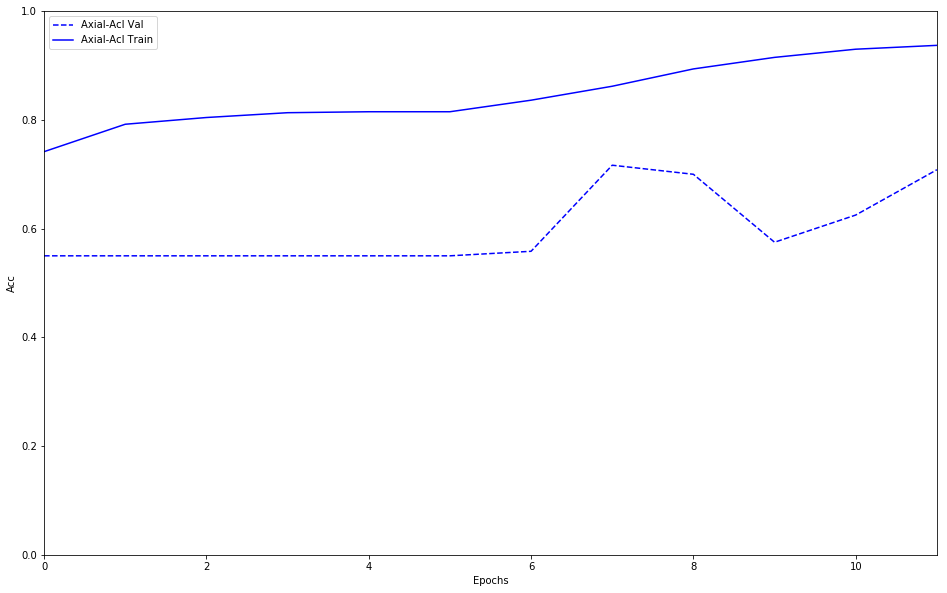

<Figure size 432x288 with 0 Axes>

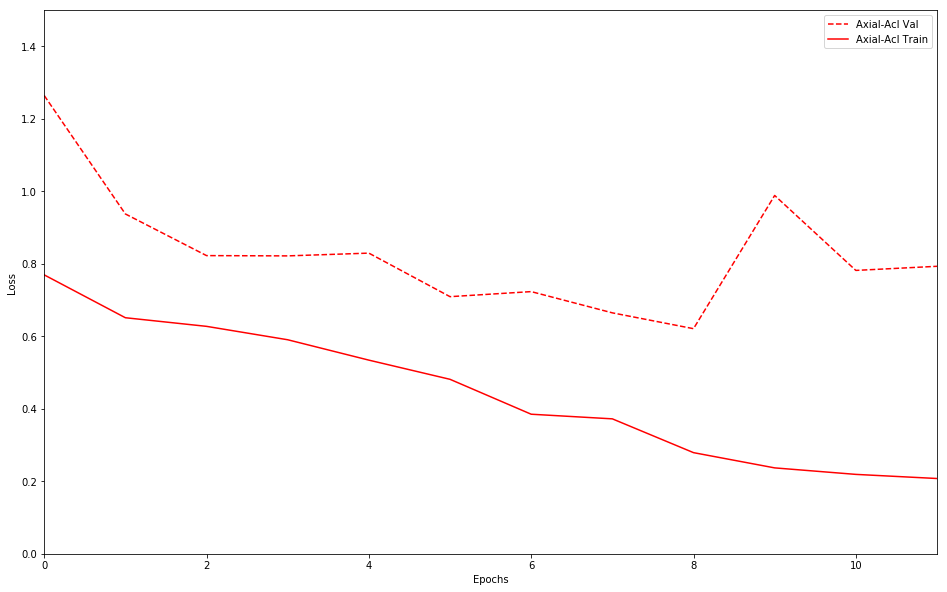

In [7]:
model = build_model()
history = train_model(model,"axial","acl")
plot_history([('Axial-ACL',history)])

## Model 2: Axial Plane and Abnormal Labels

Train on 1130 samples, validate on 120 samples
Epoch 1/50

Epoch 00001: val_acc improved from -inf to 0.79167, saving model to /content/gdrive/My Drive/Models/TransferLearning/axial_abnormal.h5
 - 10s - loss: 0.7680 - acc: 0.7035 - val_loss: 1.1200 - val_acc: 0.7917
Epoch 2/50

Epoch 00002: val_acc did not improve from 0.79167
 - 6s - loss: 0.6298 - acc: 0.7779 - val_loss: 0.7027 - val_acc: 0.7917
Epoch 3/50

Epoch 00003: val_acc did not improve from 0.79167
 - 6s - loss: 0.5258 - acc: 0.7938 - val_loss: 0.8085 - val_acc: 0.7917
Epoch 4/50

Epoch 00004: val_acc did not improve from 0.79167
 - 6s - loss: 0.4768 - acc: 0.8018 - val_loss: 1.2211 - val_acc: 0.7917
Epoch 5/50

Epoch 00005: val_acc improved from 0.79167 to 0.82500, saving model to /content/gdrive/My Drive/Models/TransferLearning/axial_abnormal.h5
 - 8s - loss: 0.4287 - acc: 0.8080 - val_loss: 0.4712 - val_acc: 0.8250
Epoch 6/50

Epoch 00006: val_acc did not improve from 0.82500
 - 6s - loss: 0.4106 - acc: 0.8053 - val_loss: 

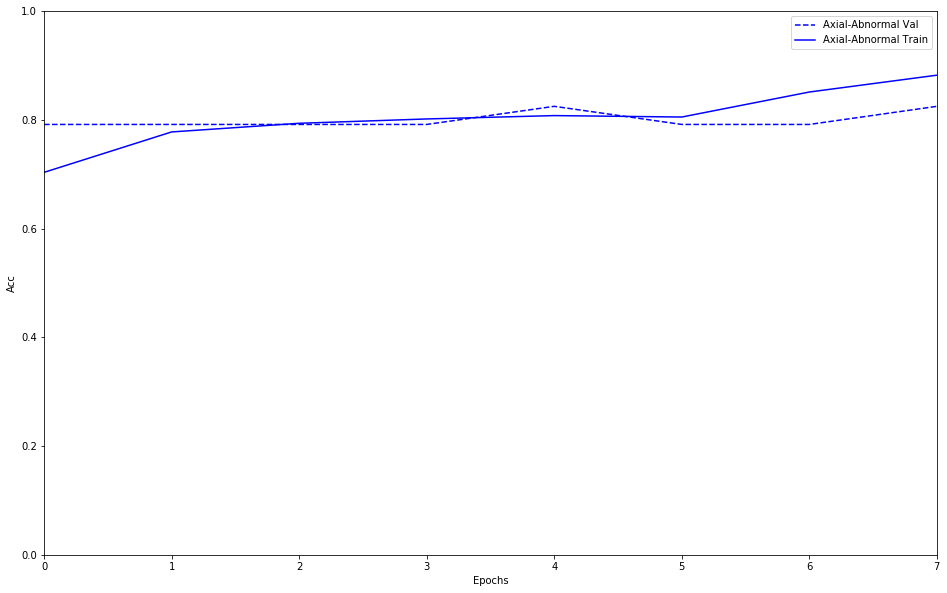

<Figure size 432x288 with 0 Axes>

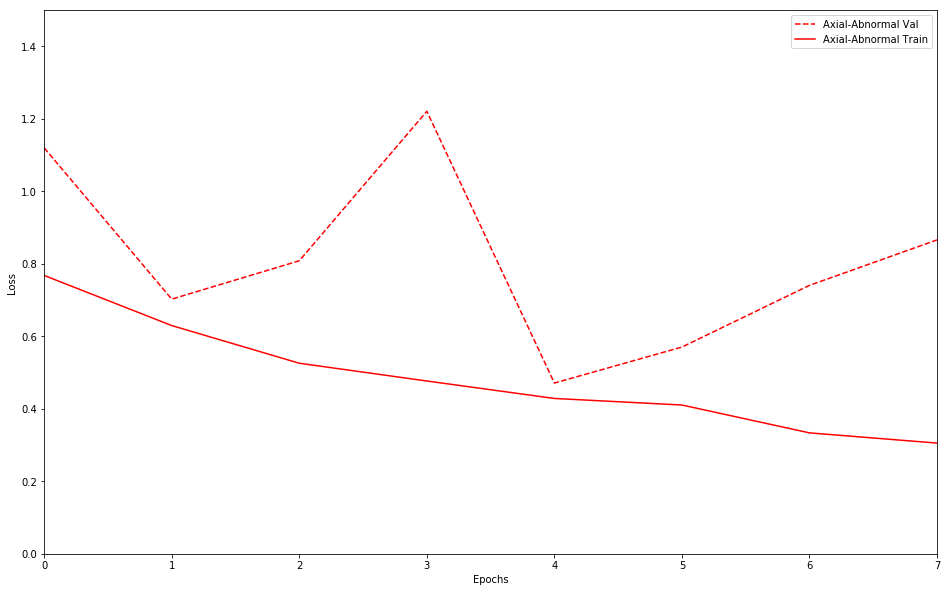

In [8]:
model = build_model()
history = train_model(model,"axial","abnormal")
plot_history([('Axial-Abnormal',history)])

## Model 3: Axial Plane and Meniscus Labels

Train on 1130 samples, validate on 120 samples
Epoch 1/50

Epoch 00001: val_acc improved from -inf to 0.56667, saving model to /content/gdrive/My Drive/Models/TransferLearning/axial_meniscus.h5
 - 11s - loss: 0.9171 - acc: 0.5796 - val_loss: 0.9122 - val_acc: 0.5667
Epoch 2/50

Epoch 00002: val_acc did not improve from 0.56667
 - 6s - loss: 0.7736 - acc: 0.6274 - val_loss: 0.7824 - val_acc: 0.5667
Epoch 3/50

Epoch 00003: val_acc did not improve from 0.56667
 - 6s - loss: 0.7577 - acc: 0.6248 - val_loss: 0.7540 - val_acc: 0.5667
Epoch 4/50

Epoch 00004: val_acc improved from 0.56667 to 0.59167, saving model to /content/gdrive/My Drive/Models/TransferLearning/axial_meniscus.h5
 - 8s - loss: 0.7041 - acc: 0.6743 - val_loss: 0.7453 - val_acc: 0.5917
Epoch 5/50

Epoch 00005: val_acc did not improve from 0.59167
 - 6s - loss: 0.6751 - acc: 0.6761 - val_loss: 0.7530 - val_acc: 0.5667
Epoch 6/50

Epoch 00006: val_acc did not improve from 0.59167
 - 6s - loss: 0.6583 - acc: 0.6575 - val_loss: 

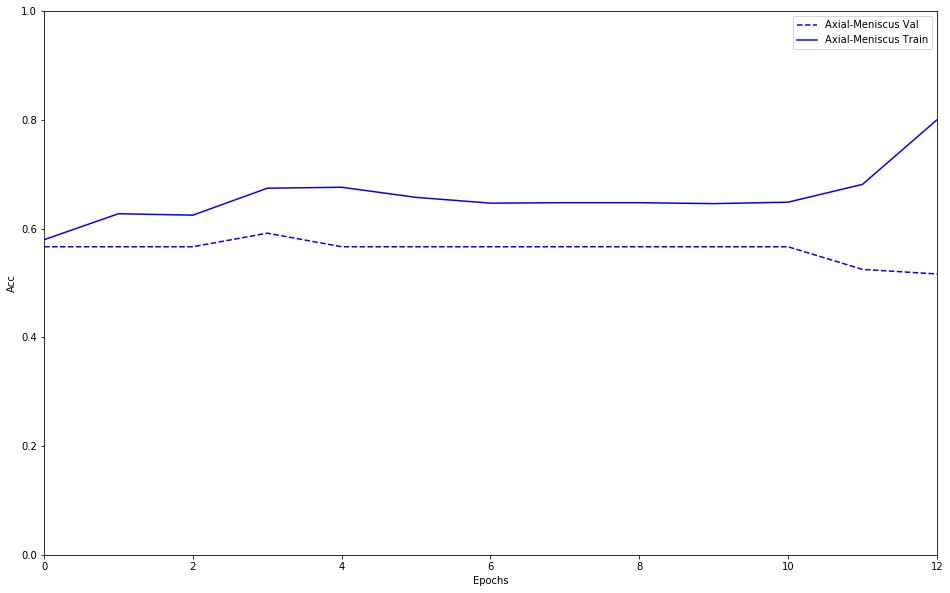

<Figure size 432x288 with 0 Axes>

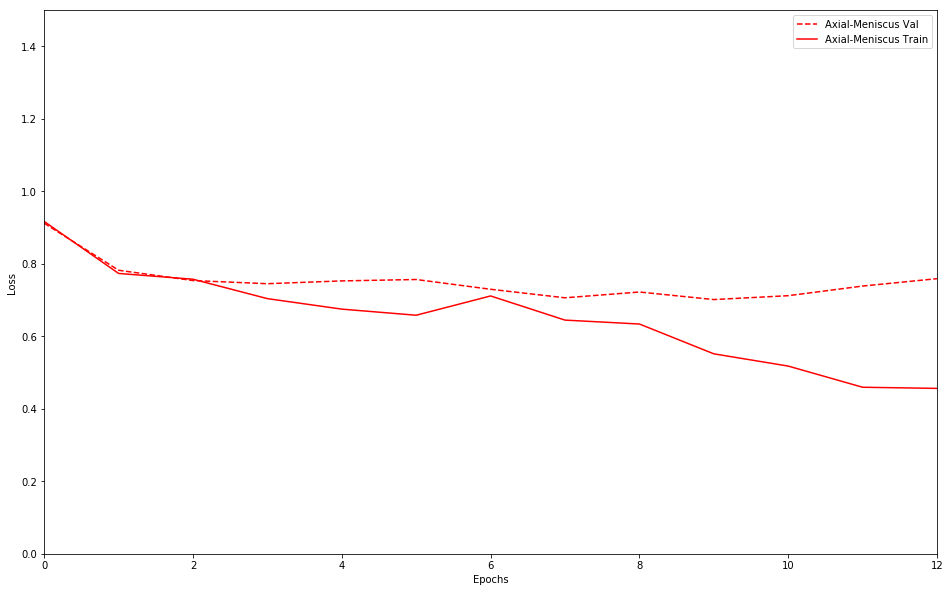

In [9]:
model = build_model()
history = train_model(model,"axial","meniscus")
plot_history([('Axial-Meniscus',history)])

## Model 4: Coronol Plane and ACL Labels

Train on 1130 samples, validate on 120 samples
Epoch 1/50

Epoch 00001: val_acc improved from -inf to 0.55000, saving model to /content/gdrive/My Drive/Models/TransferLearning/coronal_acl.h5
 - 11s - loss: 0.7720 - acc: 0.7292 - val_loss: 1.3147 - val_acc: 0.5500
Epoch 2/50

Epoch 00002: val_acc did not improve from 0.55000
 - 6s - loss: 0.6453 - acc: 0.7920 - val_loss: 0.8681 - val_acc: 0.5500
Epoch 3/50

Epoch 00003: val_acc did not improve from 0.55000
 - 6s - loss: 0.6330 - acc: 0.8080 - val_loss: 0.8987 - val_acc: 0.5500
Epoch 4/50

Epoch 00004: val_acc did not improve from 0.55000
 - 6s - loss: 0.5888 - acc: 0.8150 - val_loss: 0.9392 - val_acc: 0.5500
Epoch 5/50

Epoch 00005: val_acc did not improve from 0.55000
 - 6s - loss: 0.5700 - acc: 0.8159 - val_loss: 0.9503 - val_acc: 0.5500
Epoch 00005: early stopping


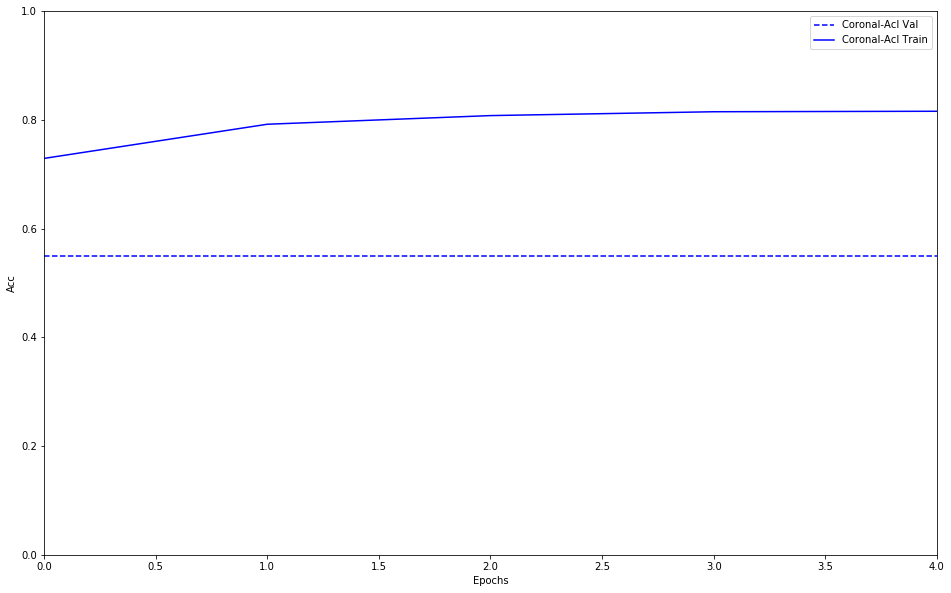

<Figure size 432x288 with 0 Axes>

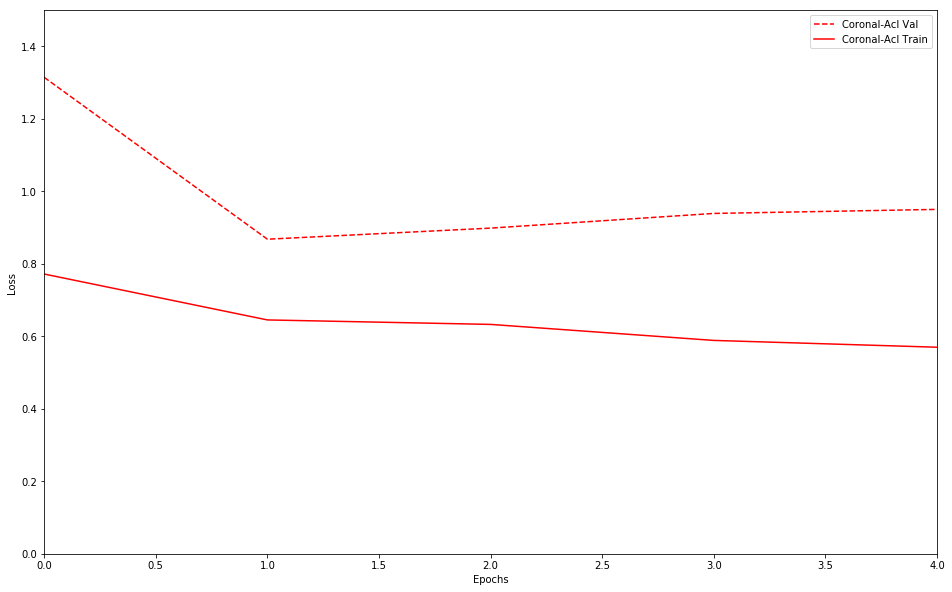

In [10]:
model = build_model()
history = train_model(model,"coronal","acl")
plot_history([('Coronal-ACL',history)])

## Model 5: Coronol Plane and Abnormal Labels

Train on 1130 samples, validate on 120 samples
Epoch 1/50

Epoch 00001: val_acc improved from -inf to 0.79167, saving model to /content/gdrive/My Drive/Models/TransferLearning/coronal_abnormal.h5
 - 12s - loss: 0.7907 - acc: 0.6903 - val_loss: 0.7304 - val_acc: 0.7917
Epoch 2/50

Epoch 00002: val_acc did not improve from 0.79167
 - 6s - loss: 0.6617 - acc: 0.7425 - val_loss: 0.6097 - val_acc: 0.7917
Epoch 3/50

Epoch 00003: val_acc did not improve from 0.79167
 - 6s - loss: 0.5915 - acc: 0.7903 - val_loss: 0.6071 - val_acc: 0.7917
Epoch 4/50

Epoch 00004: val_acc did not improve from 0.79167
 - 6s - loss: 0.5424 - acc: 0.8062 - val_loss: 0.5886 - val_acc: 0.7917
Epoch 5/50

Epoch 00005: val_acc did not improve from 0.79167
 - 6s - loss: 0.4532 - acc: 0.8053 - val_loss: 0.6655 - val_acc: 0.7917
Epoch 6/50

Epoch 00006: val_acc improved from 0.79167 to 0.80000, saving model to /content/gdrive/My Drive/Models/TransferLearning/coronal_abnormal.h5
 - 8s - loss: 0.3814 - acc: 0.8336 - val_lo

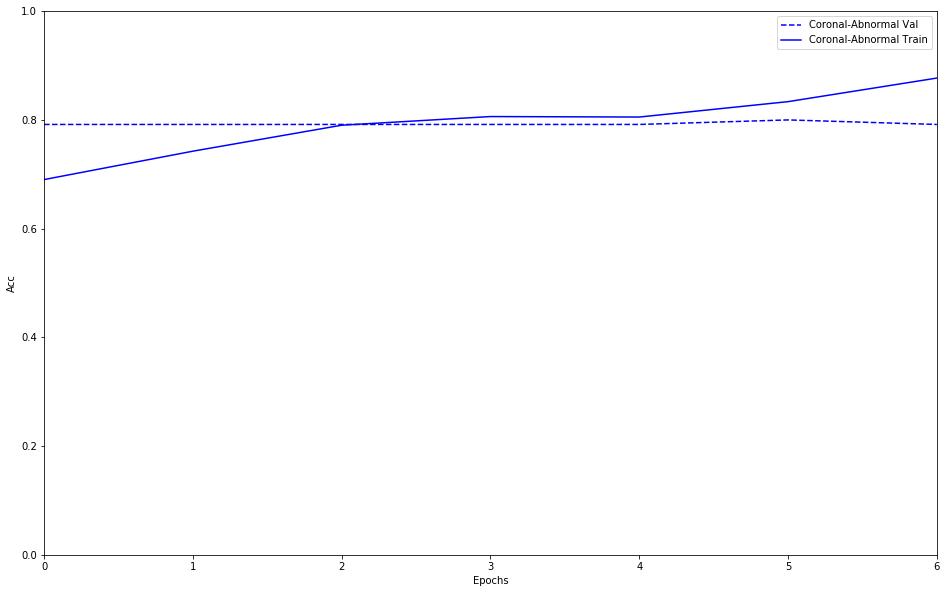

<Figure size 432x288 with 0 Axes>

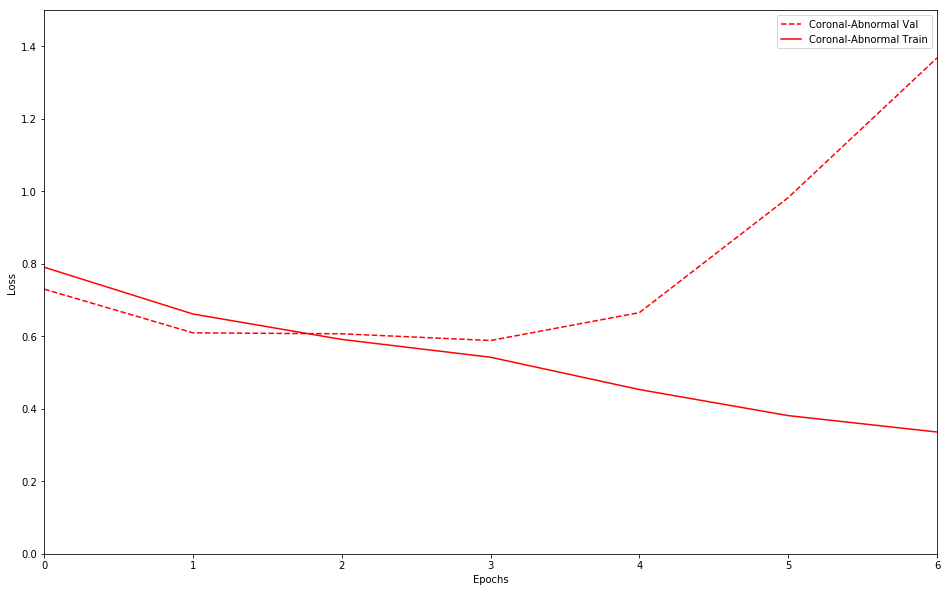

In [11]:
model = build_model()
history = train_model(model,"coronal","abnormal")
plot_history([('Coronal-Abnormal',history)])

## Model 6: Coronol Plane and Meniscus Labels

Train on 1130 samples, validate on 120 samples
Epoch 1/50

Epoch 00001: val_acc improved from -inf to 0.56667, saving model to /content/gdrive/My Drive/Models/TransferLearning/coronal_meniscus.h5
 - 12s - loss: 0.8588 - acc: 0.5885 - val_loss: 1.0210 - val_acc: 0.5667
Epoch 2/50

Epoch 00002: val_acc did not improve from 0.56667
 - 6s - loss: 0.7590 - acc: 0.6416 - val_loss: 0.8074 - val_acc: 0.5667
Epoch 3/50

Epoch 00003: val_acc did not improve from 0.56667
 - 6s - loss: 0.7308 - acc: 0.6434 - val_loss: 0.8302 - val_acc: 0.5667
Epoch 4/50

Epoch 00004: val_acc did not improve from 0.56667
 - 6s - loss: 0.7029 - acc: 0.6743 - val_loss: 0.8460 - val_acc: 0.5667
Epoch 5/50

Epoch 00005: val_acc improved from 0.56667 to 0.59167, saving model to /content/gdrive/My Drive/Models/TransferLearning/coronal_meniscus.h5
 - 8s - loss: 0.6581 - acc: 0.7018 - val_loss: 0.7418 - val_acc: 0.5917
Epoch 6/50

Epoch 00006: val_acc did not improve from 0.59167
 - 6s - loss: 0.5925 - acc: 0.7487 - val_lo

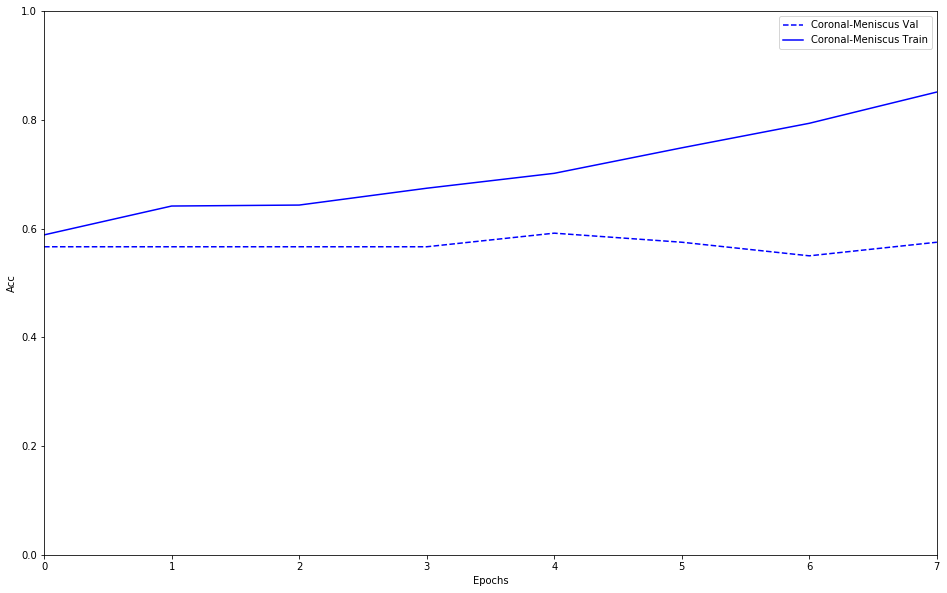

<Figure size 432x288 with 0 Axes>

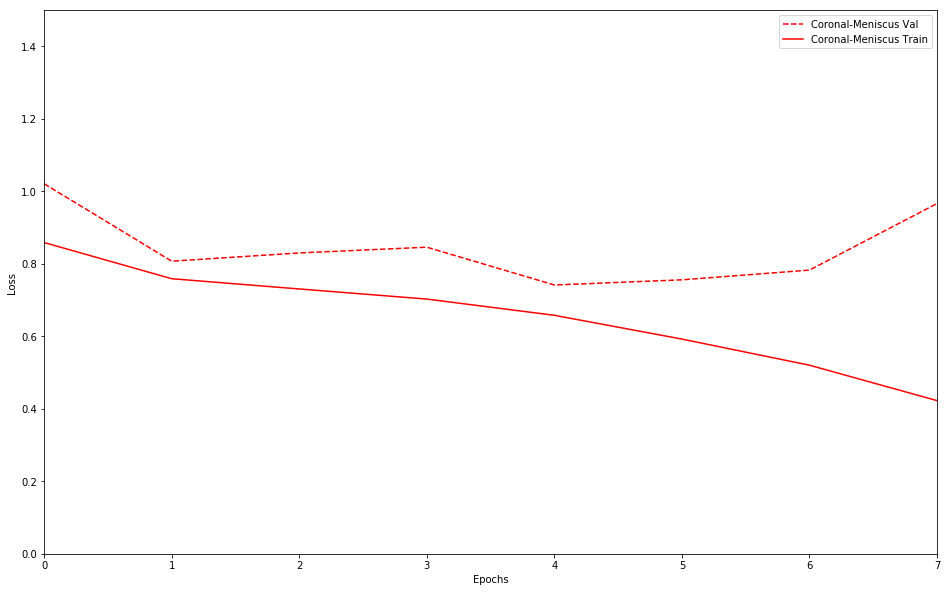

In [12]:
model = build_model()
history = train_model(model,"coronal","meniscus")
plot_history([('Coronal-Meniscus',history)])

## Model 7: Sagittal Plane and ACL Labels

Train on 1130 samples, validate on 120 samples
Epoch 1/50

Epoch 00001: val_acc improved from -inf to 0.55000, saving model to /content/gdrive/My Drive/Models/TransferLearning/sagittal_acl.h5
 - 13s - loss: 0.7183 - acc: 0.7611 - val_loss: 1.7148 - val_acc: 0.5500
Epoch 2/50

Epoch 00002: val_acc did not improve from 0.55000
 - 6s - loss: 0.6449 - acc: 0.7973 - val_loss: 1.1595 - val_acc: 0.5500
Epoch 3/50

Epoch 00003: val_acc did not improve from 0.55000
 - 6s - loss: 0.5795 - acc: 0.8097 - val_loss: 0.9690 - val_acc: 0.5500
Epoch 4/50

Epoch 00004: val_acc did not improve from 0.55000
 - 6s - loss: 0.5330 - acc: 0.8133 - val_loss: 0.8223 - val_acc: 0.5500
Epoch 5/50

Epoch 00005: val_acc did not improve from 0.55000
 - 6s - loss: 0.4776 - acc: 0.8142 - val_loss: 1.1402 - val_acc: 0.5500
Epoch 6/50

Epoch 00006: val_acc did not improve from 0.55000
 - 6s - loss: 0.3898 - acc: 0.8177 - val_loss: 1.4149 - val_acc: 0.5500
Epoch 7/50

Epoch 00007: val_acc improved from 0.55000 to 0.62500

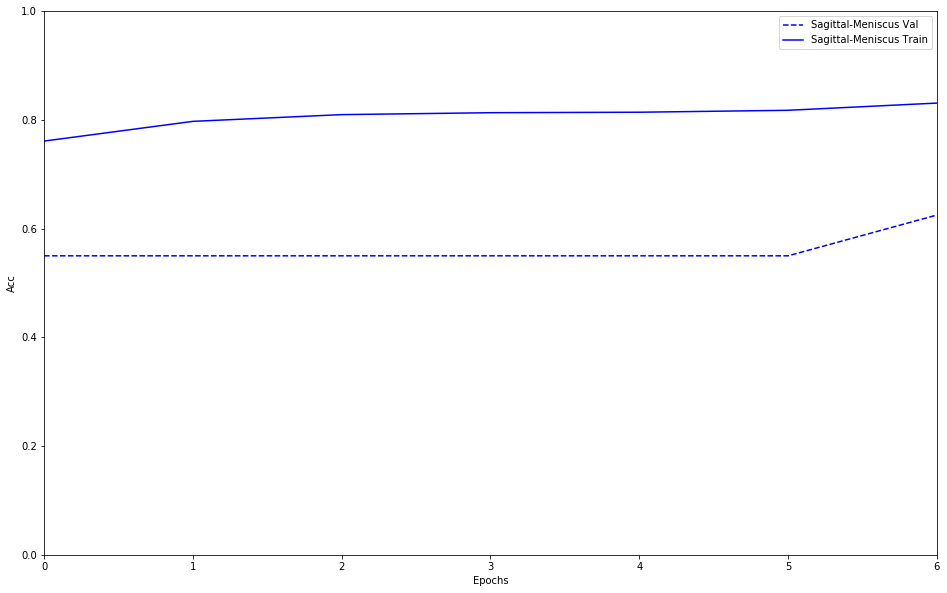

<Figure size 432x288 with 0 Axes>

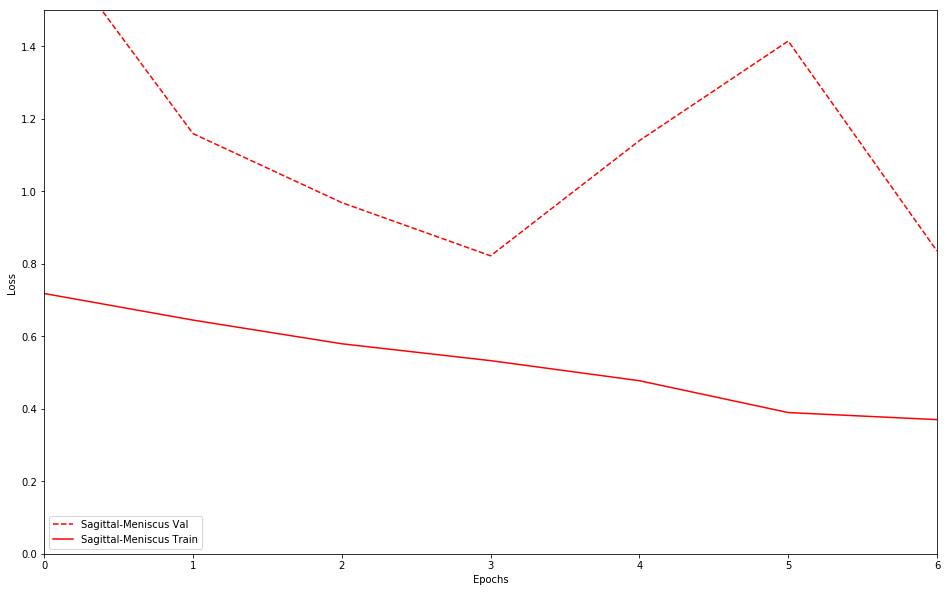

In [13]:
model = build_model()
history = train_model(model,"sagittal","acl")
plot_history([('Sagittal-Meniscus',history)])

## Model 8: Sagittal Plane and Abnormal Labels

Train on 1130 samples, validate on 120 samples
Epoch 1/50

Epoch 00001: val_acc improved from -inf to 0.79167, saving model to /content/gdrive/My Drive/Models/TransferLearning/sagittal_abnormal.h5
 - 14s - loss: 0.7906 - acc: 0.6894 - val_loss: 0.7545 - val_acc: 0.7917
Epoch 2/50

Epoch 00002: val_acc did not improve from 0.79167
 - 6s - loss: 0.6378 - acc: 0.7929 - val_loss: 0.6018 - val_acc: 0.7917
Epoch 3/50

Epoch 00003: val_acc did not improve from 0.79167
 - 6s - loss: 0.5608 - acc: 0.7965 - val_loss: 0.6313 - val_acc: 0.7917
Epoch 4/50

Epoch 00004: val_acc did not improve from 0.79167
 - 6s - loss: 0.4828 - acc: 0.8168 - val_loss: 0.5715 - val_acc: 0.7917
Epoch 5/50

Epoch 00005: val_acc did not improve from 0.79167
 - 6s - loss: 0.4185 - acc: 0.8283 - val_loss: 0.6063 - val_acc: 0.7917
Epoch 6/50

Epoch 00006: val_acc did not improve from 0.79167
 - 6s - loss: 0.3235 - acc: 0.8743 - val_loss: 0.7995 - val_acc: 0.7917
Epoch 7/50

Epoch 00007: val_acc did not improve from 0.7916

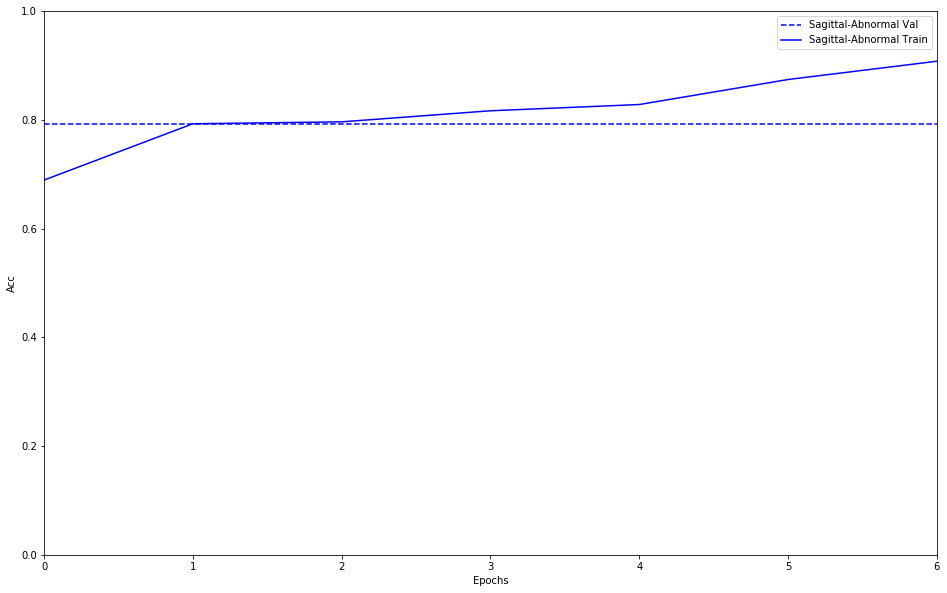

<Figure size 432x288 with 0 Axes>

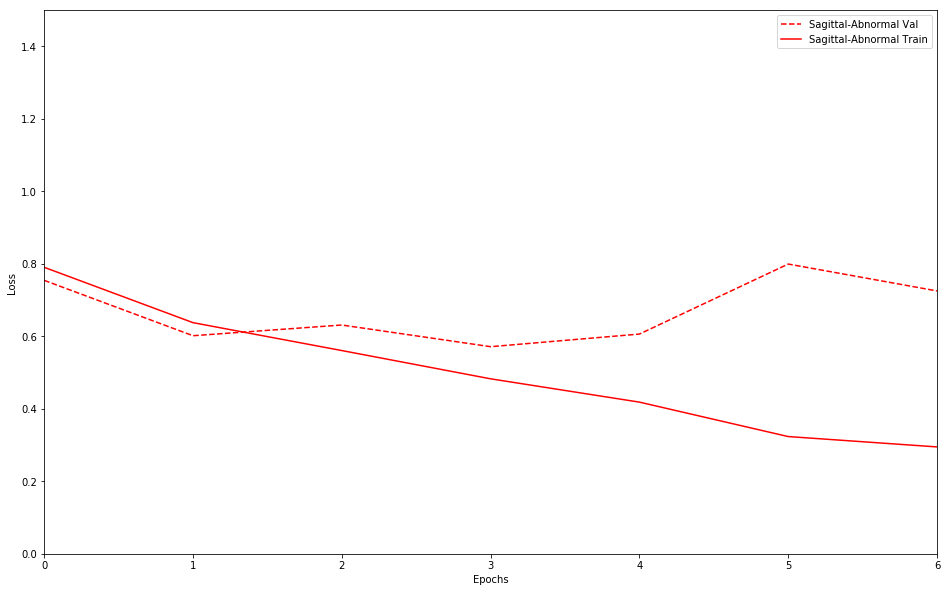

In [14]:
model = build_model()
history = train_model(model,"sagittal","abnormal")
plot_history([('Sagittal-Abnormal',history)])

## Model 9: Sagittal Plane and Meniscus Labels

Train on 1130 samples, validate on 120 samples
Epoch 1/50

Epoch 00001: val_acc improved from -inf to 0.56667, saving model to /content/gdrive/My Drive/Models/TransferLearning/sagittal_meniscus.h5
 - 14s - loss: 0.8947 - acc: 0.5558 - val_loss: 0.8209 - val_acc: 0.5667
Epoch 2/50

Epoch 00002: val_acc did not improve from 0.56667
 - 6s - loss: 0.7979 - acc: 0.6106 - val_loss: 0.8007 - val_acc: 0.5667
Epoch 3/50

Epoch 00003: val_acc did not improve from 0.56667
 - 6s - loss: 0.7657 - acc: 0.6274 - val_loss: 0.7800 - val_acc: 0.5667
Epoch 4/50

Epoch 00004: val_acc did not improve from 0.56667
 - 6s - loss: 0.7489 - acc: 0.6416 - val_loss: 0.7725 - val_acc: 0.5667
Epoch 5/50

Epoch 00005: val_acc did not improve from 0.56667
 - 6s - loss: 0.7310 - acc: 0.6478 - val_loss: 0.7555 - val_acc: 0.5667
Epoch 6/50

Epoch 00006: val_acc did not improve from 0.56667
 - 6s - loss: 0.7144 - acc: 0.6478 - val_loss: 0.7480 - val_acc: 0.5667
Epoch 7/50

Epoch 00007: val_acc did not improve from 0.5666

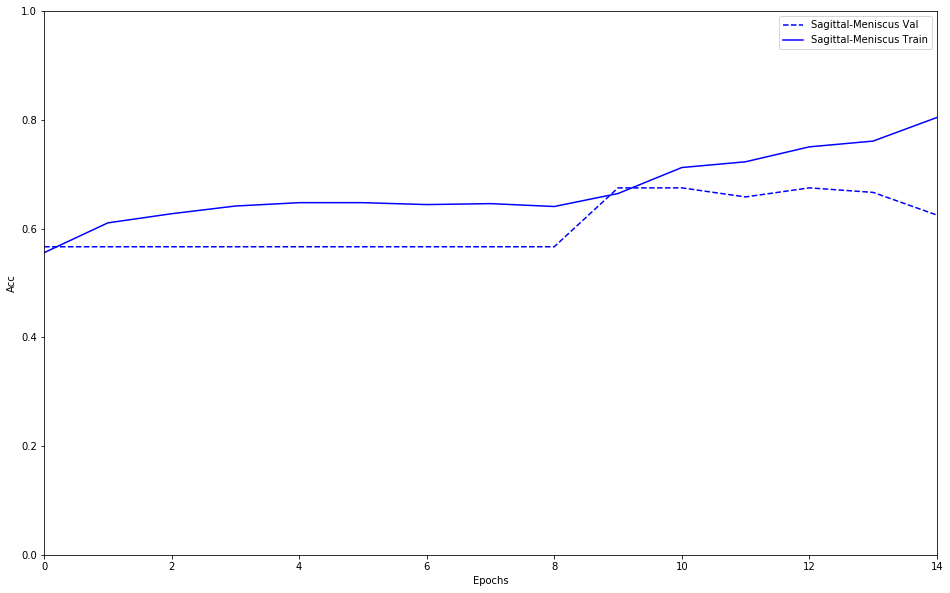

<Figure size 432x288 with 0 Axes>

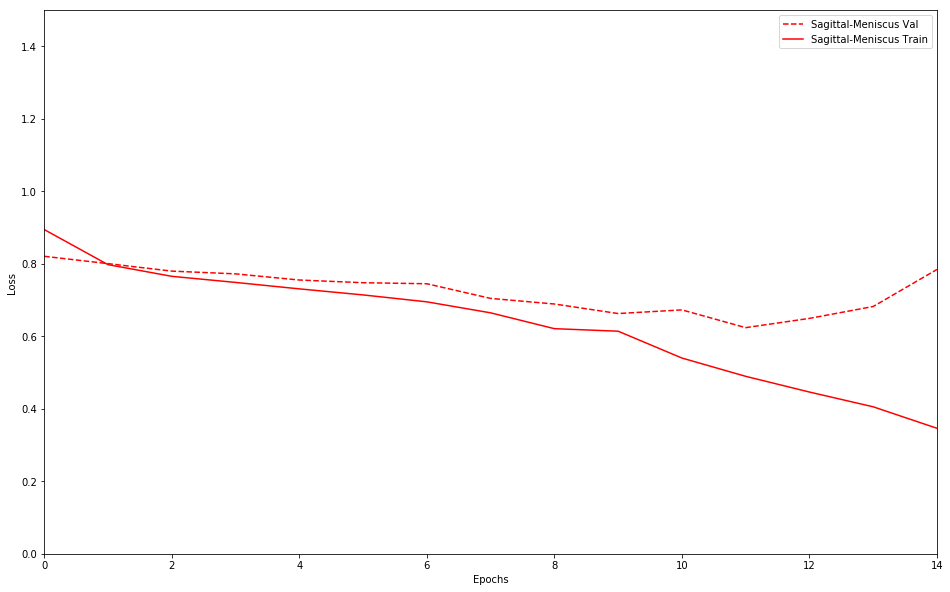

In [15]:
model = build_model()
history = train_model(model,"sagittal","meniscus")
plot_history([('Sagittal-Meniscus',history)])